In [1]:
# Install dependencies
!pip install imblearn xgboost --quiet


In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc


In [3]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [4]:
#Step 1: Load dataset
df = pd.read_csv('/content/parkinsons.data')
df.drop(['name'], axis=1, inplace=True)

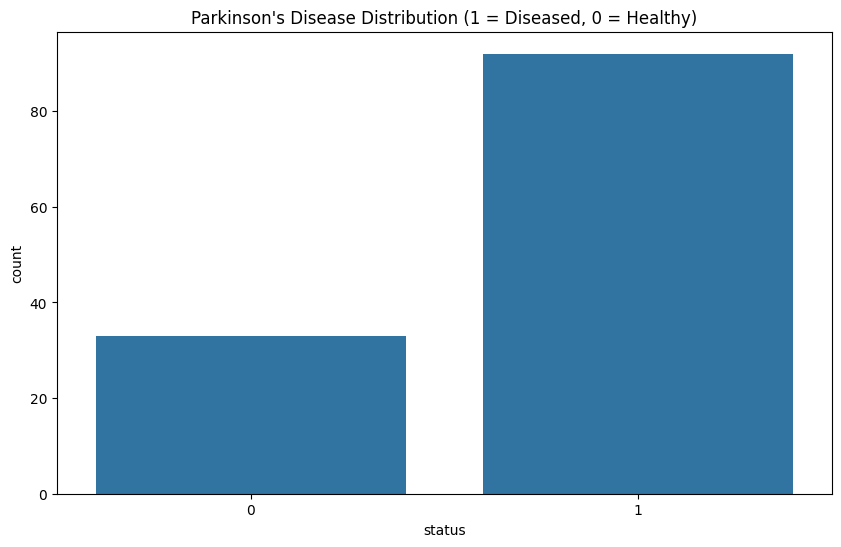

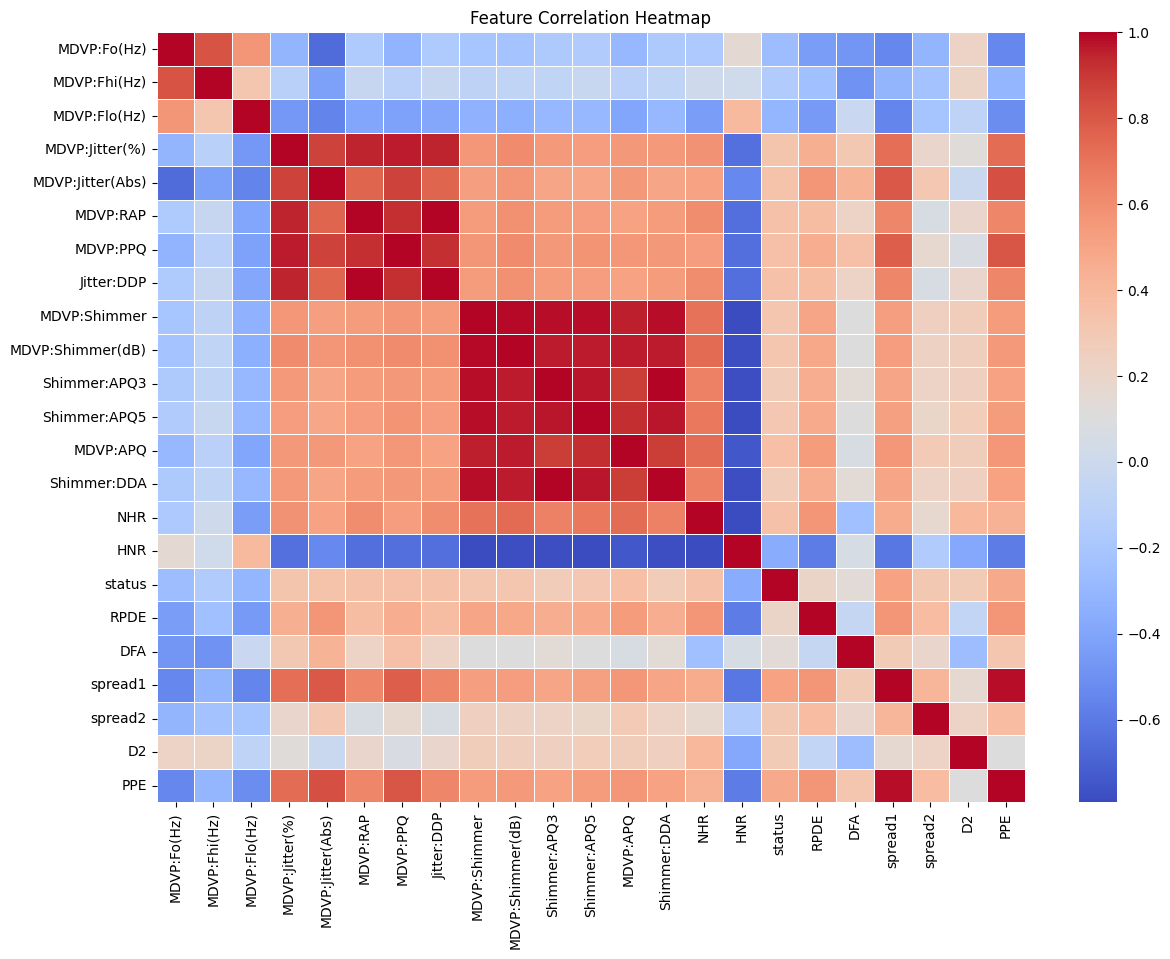

In [12]:
#Step 2: Basic EDA
plt.figure(figsize=(10, 6))
sns.countplot(x=df['status'])
plt.title("Parkinson's Disease Distribution (1 = Diseased, 0 = Healthy)")
plt.show()

# Correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [13]:
#Step 3: Remove outliers using IQR
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

for col in df.columns.drop('status'):
    df = remove_outliers(df, col)

In [14]:
 #Step 4: Prepare data
X = df.drop('status', axis=1)
y = df['status']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handle imbalance
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_scaled, y)

In [15]:
#Step 5: Feature selection
selector = RFE(RandomForestClassifier(random_state=42), n_features_to_select=12)
X_selected = selector.fit_transform(X_res, y_res)
selected_features = X.columns[selector.support_]
print("Selected features:", list(selected_features))

Selected features: ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'NHR', 'RPDE', 'spread1', 'D2', 'PPE']


In [16]:
#Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_res, test_size=0.2, random_state=42, stratify=y_res
)


In [17]:
#Step 7: Define ensemble model
voting_clf = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('svc', SVC(probability=True, random_state=42))
], voting='soft')

In [18]:
#Step 8: Train model
voting_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importanc...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

✅ Accuracy: 90.32%

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91        16
           1       0.93      0.87      0.90        15

    accuracy                           0.90        31
   macro avg       0.91      0.90      0.90        31
weighted avg       0.90      0.90      0.90        31



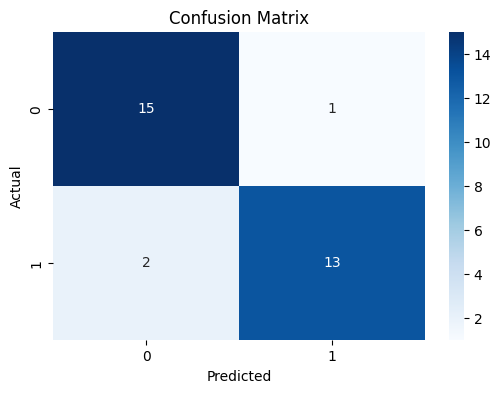

Cross-Validation Scores: [0.83870968 0.83870968 0.83333333 0.9        0.9       ]
Mean Cross-Validation Accuracy: 86.22%


In [19]:
#Step 9: Evaluate model
y_pred = voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {accuracy*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Cross-validation
cv_scores = cross_val_score(voting_clf, X_selected, y_res, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores)*100:.2f}%")


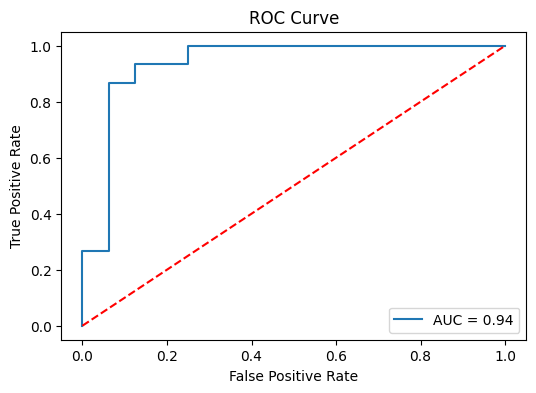

In [22]:
#  ROC Curve
y_proba = voting_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'r--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.show()


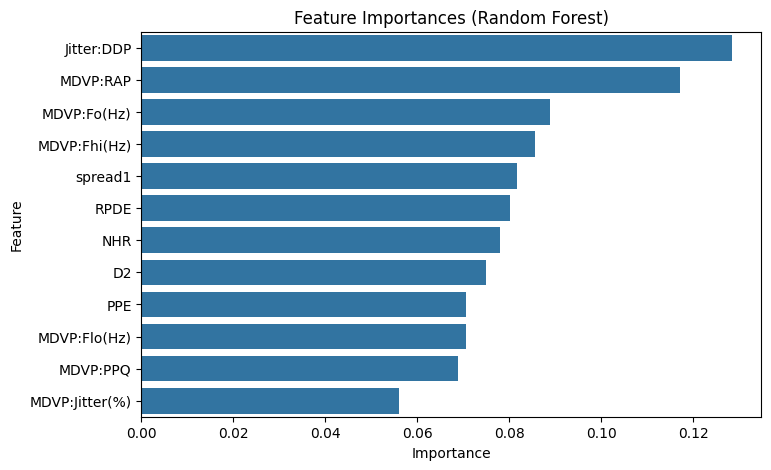

In [23]:
# 11️⃣ Feature importance plot using Random Forest for interpretation
rf_temp = RandomForestClassifier(random_state=42)
rf_temp.fit(X_res[:, selector.support_], y_res)
importances = rf_temp.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
sns.barplot(x=importances[indices], y=np.array(selected_features)[indices])
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [24]:
#  Cross-validation accuracy
cv_scores = cross_val_score(voting_clf, X_selected, y_res, cv=5)
print("\n✅ Cross-Validation Scores:", cv_scores)
print(f"✅ Mean Cross-Validation Accuracy: {cv_scores.mean():.4f}")


✅ Cross-Validation Scores: [0.83870968 0.83870968 0.83333333 0.9        0.9       ]
✅ Mean Cross-Validation Accuracy: 0.8622
